[Reference](https://medium.com/@francescofranco_39234/adam-optimization-with-pytorch-a76195c85587)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# Define a simple linear regression model
class LinearRegression(nn.Module):
    def __init__(self, input_dim):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.linear(x)

# Generate synthetic data
np.random.seed(42)
X = np.random.rand(100, 1) * 10  # 100 samples, 1 feature
y = 3 * X + 5 + np.random.randn(100, 1) * 2  # y = 3x + 5 + noise

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Create dataset and dataloader
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

In [3]:
# Initialize model
model = LinearRegression(input_dim=1)

# Loss function
criterion = nn.MSELoss()

# ADAM hyperparameters
learning_rate = 0.01
beta1 = 0.9  # for momentum
beta2 = 0.999  # for RMSprop
epsilon = 1e-8

# Initialize ADAM parameters
m = [torch.zeros_like(p) for p in model.parameters()]  # First moment vector
v = [torch.zeros_like(p) for p in model.parameters()]  # Second moment vector
t = 0  # Time step

In [4]:
num_epochs = 100
losses = []

for epoch in range(num_epochs):
    for batch_X, batch_y in dataloader:
        t += 1  # Increment time step

        # 1. Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        losses.append(loss.item())

        # 2. Zero gradients
        model.zero_grad()

        # 3. Backward pass (compute gradients)
        loss.backward()

        # 4. ADAM parameter update
        with torch.no_grad():
            for i, (param, grad) in enumerate(zip(model.parameters(), [p.grad for p in model.parameters()])):
                # Update biased first moment estimate
                m[i] = beta1 * m[i] + (1 - beta1) * grad

                # Update biased second raw moment estimate
                v[i] = beta2 * v[i] + (1 - beta2) * (grad ** 2)

                # Compute bias-corrected first moment estimate
                m_hat = m[i] / (1 - beta1 ** t)

                # Compute bias-corrected second raw moment estimate
                v_hat = v[i] / (1 - beta2 ** t)

                # Update parameters
                param.data -= learning_rate * m_hat / (torch.sqrt(v_hat) + epsilon)

In [5]:
# Reinitialize model
model_builtin = LinearRegression(input_dim=1)

# Use PyTorch's built-in ADAM optimizer
optimizer = optim.Adam(model_builtin.parameters(), lr=learning_rate, betas=(beta1, beta2), eps=epsilon)

# Training loop with built-in ADAM
losses_builtin = []
for epoch in range(num_epochs):
    for batch_X, batch_y in dataloader:
        # Forward pass
        outputs = model_builtin(batch_X)
        loss = criterion(outputs, batch_y)
        losses_builtin.append(loss.item())

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

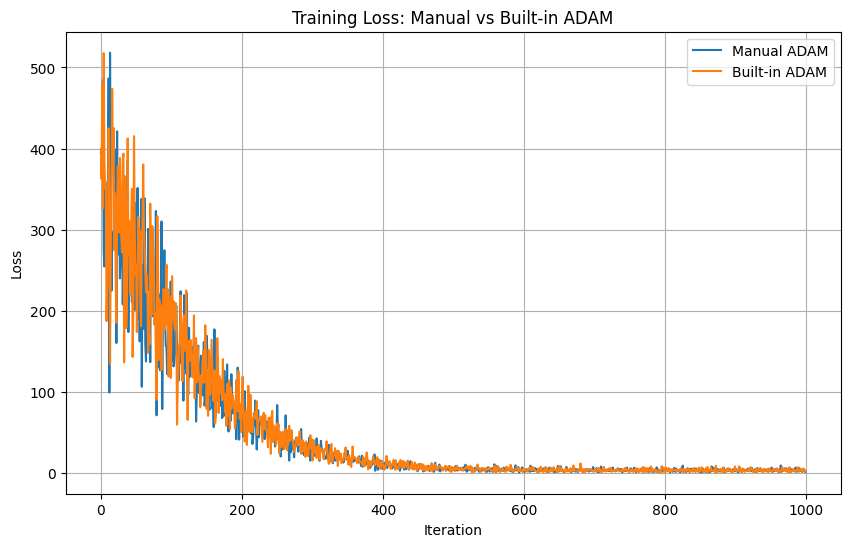

Manual ADAM final parameters:
linear.weight: tensor([[3.1177]])
linear.bias: tensor([4.1206])

Built-in ADAM final parameters:
linear.weight: tensor([[3.1274]])
linear.bias: tensor([4.0505])


In [6]:
plt.figure(figsize=(10, 6))
plt.plot(losses, label='Manual ADAM')
plt.plot(losses_builtin, label='Built-in ADAM')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss: Manual vs Built-in ADAM')
plt.legend()
plt.grid(True)
plt.show()

# Print final parameters
print("Manual ADAM final parameters:")
for name, param in model.named_parameters():
    print(f"{name}: {param.data}")

print("\nBuilt-in ADAM final parameters:")
for name, param in model_builtin.named_parameters():
    print(f"{name}: {param.data}")